In [1]:
!pip install transformers==4.30.2 accelerate==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/InfosysSB/Preprocessed_Dataset/FakeNewsNet_Preprocessed.csv')


In [6]:
# Show the first few rows of the dataset
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation on real...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,people choice award 2018 the best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma spark rumour of inappr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl 10 year later upper east siders sh...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


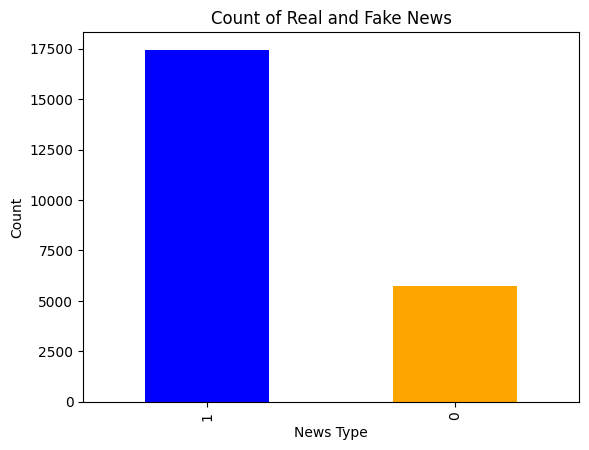

In [7]:
# Show the count of real and fake news
df['real'].value_counts().plot(kind='bar', color=['blue', 'orange'], title='Count of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()


In [8]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [9]:
# Prepare the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

X = df['title'].values
y = df['real'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42)

train_dataset = FakeNewsDataset(X_train, y_train, tokenizer, max_len)
val_dataset = FakeNewsDataset(X_val, y_val, tokenizer, max_len)
test_dataset = FakeNewsDataset(X_test, y_test, tokenizer, max_len)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Create the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Correct the deprecated usage
    save_total_limit=1,
)

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation results: {eval_result}")

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_test_pred = np.argmax(predictions.predictions, axis=1)
y_test_true = y_test


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.313600,0.406806,0.842968,0.900110,0.864979,0.938215
2,0.329800,0.384958,0.847714,0.898534,0.902946,0.894165
3,0.116600,0.552951,0.845988,0.899747,0.883618,0.916476


Validation results: {'eval_loss': 0.5529506206512451, 'eval_accuracy': 0.8459879206212252, 'eval_f1': 0.8997472620050548, 'eval_precision': 0.8836183121897407, 'eval_recall': 0.9164759725400458, 'eval_runtime': 18.478, 'eval_samples_per_second': 125.446, 'eval_steps_per_second': 7.847, 'epoch': 3.0}


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.73      0.65      0.68      1178
           1       0.88      0.92      0.90      3462

    accuracy                           0.85      4640
   macro avg       0.81      0.78      0.79      4640
weighted avg       0.84      0.85      0.85      4640



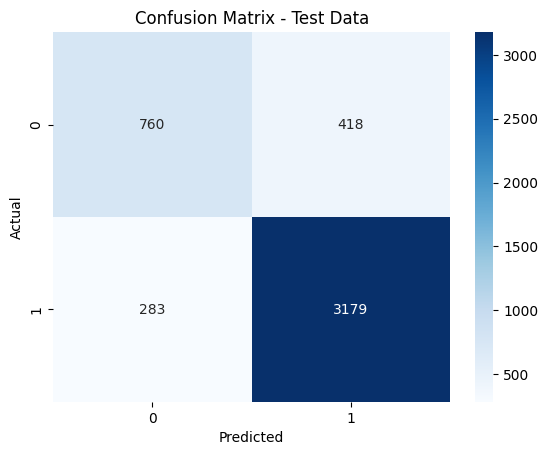

In [11]:
# Classification report for test data
print("Classification Report for Test Data:")
print(classification_report(y_test_true, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()


In [15]:
# Predict custom input
custom_input = "colombian singer maluma spark rumour of inappropriate relationship with aunt"
custom_input_encoded = tokenizer.encode_plus(
    custom_input,
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = custom_input_encoded['input_ids'].to(model.device)
attention_mask = custom_input_encoded['attention_mask'].to(model.device)

with torch.no_grad():
    output = model(input_ids, attention_mask=attention_mask)
    prediction = torch.argmax(output.logits, dim=1).item()

print("Prediction for custom input:", "Real" if prediction == 1 else "Fake")


Prediction for custom input: Fake
